In [ ]:
!pip install pandas numpy ace_tools scikit-learn torch tensorboard

## Handle imports

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from torch.utils.tensorboard import SummaryWriter
from model import MultiTaskMLPModel, CFVAE
import os

## Load and Filter ICU Stays

In [4]:
# Load files
icustays = pd.read_csv('mimiciii/ICUSTAYS.csv.gz', parse_dates=['INTIME', 'OUTTIME'])
patients = pd.read_csv('mimiciii/PATIENTS.csv.gz', parse_dates=['DOB'])
admissions = pd.read_csv('mimiciii/ADMISSIONS.csv.gz', parse_dates=['ADMITTIME'])

# Merge to get age
df = icustays.merge(admissions, on=['SUBJECT_ID', 'HADM_ID'], how='left')
df = df.merge(patients[['SUBJECT_ID', 'DOB']], on='SUBJECT_ID', how='left')

# Create a rough age column without triggering overflow
df['AGE_YEARS'] = df['ADMITTIME'].dt.year - df['DOB'].dt.year

# Filter for reasonable ages (e.g., 0 to 120 years)
df = df[(df['AGE_YEARS'] >= 18) & (df['AGE_YEARS'] <= 120)]

# Now safely calculate precise age
df['AGE'] = (df['ADMITTIME'] - df['DOB']).dt.total_seconds() / (60*60*24*365.242)

# ICU stay must be at least 54 hours
df = df[(df['OUTTIME'] - df['INTIME']).dt.total_seconds() / 3600 >= 54]

# Final shape
print(f"Filtered ICU stays (≥54h, age ≥18): {df.shape}")


Filtered ICU stays (≥54h, age ≥18): (24103, 32)


## Load Relevant Chart and Lab Events

In [5]:
chartevents = pd.read_csv(
    'mimiciii/CHARTEVENTS.csv.gz',
    usecols=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'CHARTTIME', 'VALUENUM'],
    parse_dates=['CHARTTIME']
)

labevents = pd.read_csv(
    'mimiciii/LABEVENTS.csv.gz',
    usecols=['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'CHARTTIME', 'VALUENUM'],
    parse_dates=['CHARTTIME']
)
chartevents_ids = {
    'HR': [211, 220045],
    'SysBP': [51, 442, 455, 6701, 220179],
    'DiasBP': [8368, 8440, 220180],
    'MAP': [456, 52, 6702, 220181],
    'RespRate': [618, 220210],
    'SpO2': [646, 220277],
    'Temp': [223761, 678]
}

labevents_ids = {
    'Glucose': [50931],
    'BUN': [51006],
    'Creatinine': [50912],
    'Sodium': [50983],
    'Potassium': [50971],
    'HCO3': [50882],
    'Hematocrit': [51221],
    'WBC': [51300],
    'Platelets': [51265],
    'Lactate': [50813]
}


## Extracting Structured Time Series from MIMIC-III Events

In [ ]:
itemid_to_feature = {itemid: feature for feature, ids in {**chartevents_ids, **labevents_ids}.items() for itemid in ids}
features = list(chartevents_ids.keys()) + list(labevents_ids.keys())

# --- Filter & Preprocess Once ---
chartevents = chartevents[chartevents['ITEMID'].isin(itemid_to_feature)].copy()
labevents = labevents[labevents['ITEMID'].isin(itemid_to_feature)].copy()
chartevents['FEATURE'] = chartevents['ITEMID'].map(itemid_to_feature)
labevents['FEATURE'] = labevents['ITEMID'].map(itemid_to_feature)

ce_grouped = chartevents.groupby('ICUSTAY_ID')
le_grouped = labevents.groupby('HADM_ID')

# --- Loop Over ICU Stays ---
X = []
ids = []

for _, row in df.iterrows():
    subject_id = row['SUBJECT_ID']
    hadm_id = row['HADM_ID']
    icustay_id = row['ICUSTAY_ID']
    intime = pd.to_datetime(row['INTIME'])

    ce = ce_grouped.get_group(icustay_id) if icustay_id in ce_grouped.groups else pd.DataFrame(columns=['CHARTTIME', 'FEATURE', 'VALUENUM'])
    le = le_grouped.get_group(hadm_id) if hadm_id in le_grouped.groups else pd.DataFrame(columns=['CHARTTIME', 'FEATURE', 'VALUENUM'])

    ce = ce.copy()
    le = le.copy()
    ce['HOUR'] = ce['CHARTTIME'].apply(lambda x: (pd.to_datetime(x) - intime).total_seconds() // 3600).astype(int)

    le['HOUR'] = le['CHARTTIME'].apply(lambda x: (pd.to_datetime(x) - intime).total_seconds() // 3600).astype(int)

    ce = ce[(ce['HOUR'] >= 0) & (ce['HOUR'] < 48)]
    le = le[(le['HOUR'] >= 0) & (le['HOUR'] < 48)]

    all_events = pd.concat([ce[['HOUR', 'FEATURE', 'VALUENUM']], le[['HOUR', 'FEATURE', 'VALUENUM']]])
    pivot = all_events.groupby(['HOUR', 'FEATURE'])['VALUENUM'].mean().unstack(fill_value=np.nan)
    pivot = pivot.reindex(columns=features, fill_value=np.nan).reindex(index=range(48), fill_value=np.nan)

    X.append(pivot.values)
    ids.append((subject_id, hadm_id, icustay_id))

X = np.stack(X)  
ids = np.array(ids)

In [36]:
print(f"Total ICU stays with valid 48-hour data: {len(X)}")
import pandas as pd
import numpy as np

# Step 0: Ensure X is a proper float array
X_float = np.array(X, dtype=np.float32)

# Step 1: Keep only patients with at least one non-NaN value
valid_mask = ~np.isnan(X_float).all(axis=(1, 2))  # True for patients with some valid data
X_valid = X_float[valid_mask]

# Step 2: Now compute per-patient means (across time)
X_avg = np.nanmean(X_valid, axis=1)  # shape: (N_valid, 17)

# Step 3: Summary statistics across patients
feature_summary = pd.DataFrame({
    "Feature": features,
    "Mean": np.nanmean(X_avg, axis=0).round(2),
    "Std Dev": np.nanstd(X_avg, axis=0).round(2)
})

feature_summary




Total ICU stays with valid 48-hour data: 24103


/var/folders/6q/3f3mzdfn0xn_c1r_1wcxjp9r0000gn/T/ipykernel_26512/726934241.py:13: RuntimeWarning: Mean of empty slice
  X_avg = np.nanmean(X_valid, axis=1)  # shape: (N_valid, 17)


,Feature,Mean,Std Dev
0,HR,87.099998,14.890000
1,SysBP,118.699997,17.320000
2,DiasBP,61.470001,34.040001
3,MAP,77.610001,20.209999
4,RespRate,20.459999,162.789993
5,SpO2,98.080002,138.479996
6,Temp,98.230003,4.350000
7,Glucose,136.539993,42.360001
8,BUN,27.870001,22.090000
9,Creatinine,1.510000,1.540000


## Extracting Vasopressor Intervention Labels from Input Events

In [7]:
input_mv = pd.read_csv("mimiciii/INPUTEVENTS_MV.csv.gz", usecols=["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", "ITEMID", "STARTTIME"], parse_dates=["STARTTIME"])
input_cv = pd.read_csv(
    "mimiciii/INPUTEVENTS_CV.csv.gz",
    usecols=["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", "ITEMID", "CHARTTIME"],
    parse_dates=["CHARTTIME"]
).rename(columns={"CHARTTIME": "STARTTIME"})
inputs = pd.concat([input_mv, input_cv])
vasopressor_ids = [
    30047,   # Dopamine
    30120,   # Epinephrine
    30119,   # Norepinephrine
    30309,   # Phenylephrine
    221906,  # Vasopressin
    221289,  # Norepinephrine
    221749   # Phenylephrine
]
inputs = inputs[inputs['ITEMID'].isin(vasopressor_ids)]

## Label Generation for Counterfactual Prediction

In [23]:
labels = []

for (subject_id, hadm_id, icustay_id), row in zip(ids, df.itertuples(index=False)):
    intime = pd.to_datetime(row.INTIME)
    window_start = intime + pd.Timedelta(hours=48)
    window_end = intime + pd.Timedelta(hours=54)

    given = inputs[
        (inputs['ICUSTAY_ID'] == icustay_id) &
        (inputs['STARTTIME'] >= window_start) &
        (inputs['STARTTIME'] < window_end)
    ]

    label = int(not given.empty)
    labels.append(label)

y = np.array(labels)
print(y[:10])

[1 1 0 0 0 0 0 0 0 1]


## Label Assignment Summary

In [24]:
df_labels = pd.DataFrame(ids, columns=["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID"])
df_labels["LABEL"] = y

print(df_labels.head())


   SUBJECT_ID  HADM_ID  ICUSTAY_ID  LABEL
0         268   110404      280836      1
1         269   106296      206613      1
2         270   188028      220345      0
3         274   130546      254851      0
4         275   129886      219649      0


# Train/Validation/Test Split

In [10]:

# Extract subject IDs
subject_ids = np.array([x[0] for x in ids])

# Split by subject
unique_subjects = np.unique(subject_ids)
train_subj, test_subj = train_test_split(unique_subjects, test_size=0.2, random_state=42)
val_subj, test_subj = train_test_split(test_subj, test_size=0.5, random_state=42)  # 10% val, 10% test

# Mask for each set
train_mask = np.isin(subject_ids, train_subj)
val_mask = np.isin(subject_ids, val_subj)
test_mask = np.isin(subject_ids, test_subj)

# Final splits
X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]


In [27]:
print("=== Dataset Summary ===")
print(f"Total Patients: {len(X)}")
print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

# Class balance in each split
def label_summary(y, name):
    pos = np.sum(y)
    total = len(y)
    print(f"{name} - Positives: {pos} ({pos/total:.2%}) | Negatives: {total - pos} ({(total - pos)/total:.2%})")

label_summary(y_train, "Train")
label_summary(y_val, "Val")
label_summary(y_test, "Test")


=== Dataset Summary ===
Total Patients: 24103
Train: 19280 | Val: 2403 | Test: 2420
Train - Positives: 2031 (10.53%) | Negatives: 17249 (89.47%)
Val - Positives: 248 (10.32%) | Negatives: 2155 (89.68%)
Test - Positives: 255 (10.54%) | Negatives: 2165 (89.46%)


# Feature Normalization

To standardize the input data, we compute the mean and standard deviation of each feature across all timesteps and all training examples. These statistics are computed only on the training set to avoid information leakage. We then apply the same normalization transformation to the validation and test sets. Any feature with zero variance is safely handled by setting its standard deviation to 1. This ensures all inputs are scaled consistently, improving model convergence and stability during training.

In [11]:
# Step 1: Flatten from (N, 48, 17) → (N, 816)
X_train = X_train.reshape(X_train.shape[0], -1).astype(np.float32)
X_val = X_val.reshape(X_val.shape[0], -1).astype(np.float32)
X_test = X_test.reshape(X_test.shape[0], -1).astype(np.float32)

# Step 2: Compute train-only stats
train_mean = np.nanmean(X_train, axis=0)
train_std = np.nanstd(X_train, axis=0)
train_std[train_std == 0] = 1  # prevent div-by-zero

# Step 3: Normalize
X_train = (X_train - train_mean) / train_std
X_val = (X_val - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

# Step 4: Replace NaNs *after* normalization
X_train = np.nan_to_num(X_train, nan=0.0)
X_val = np.nan_to_num(X_val, nan=0.0)
X_test = np.nan_to_num(X_test, nan=0.0)

# Step 5: Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)


/var/folders/6q/3f3mzdfn0xn_c1r_1wcxjp9r0000gn/T/ipykernel_26512/770599482.py:7: RuntimeWarning: Mean of empty slice
  train_mean = np.nanmean(X_train, axis=0)
/usr/local/anaconda3/envs/sportsbetting/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


# Train MultiTaskMLPModel

In [12]:
import time
from sklearn.metrics import roc_auc_score

# Step 1: Create dataloaders from preprocessed tensors
train_ds = TensorDataset(X_train, torch.tensor(y_train, dtype=torch.long))
val_ds = TensorDataset(X_val, torch.tensor(y_val, dtype=torch.long))
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

# Step 2: Initialize model
model = MultiTaskMLPModel(
    feat_dim=X_train.shape[1],  # 816
    inp_emb=256,
    emb_dim1=128,
    emb_dim2=64
)

# Step 3: Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Step 4: Training loop with runtime, accuracy, AUC tracking
for epoch in range(1, 11):
    start = time.time()
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        _, pred, _ = model(xb, xb)  # input is passed twice per model design
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # === Validation ===
    model.eval()
    correct = total = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in val_loader:
            _, pred, _ = model(xb, xb)
            probs = torch.softmax(pred, dim=1)
            preds = torch.argmax(probs, dim=1)

            correct += (preds == yb).sum().item()
            total += yb.size(0)

            all_probs.extend(probs[:, 1].cpu().tolist())
            all_labels.extend(yb.cpu().tolist())

    acc = correct / total
    auc = roc_auc_score(all_labels, all_probs)

    print(f"Epoch {epoch} | Time: {time.time() - start:.2f}s | Train Loss: {total_loss:.4f} | Val Acc: {acc:.4f} | AUC: {auc:.4f}")

# Step 5: Save model weights
torch.save(model.state_dict(), "predictor_multitask.pt")


Epoch 1 | Time: 1.19s | Train Loss: 95.3275 | Val Acc: 0.8980 | AUC: 0.7934
Epoch 2 | Time: 1.38s | Train Loss: 81.2355 | Val Acc: 0.9001 | AUC: 0.8143
Epoch 3 | Time: 1.22s | Train Loss: 75.8780 | Val Acc: 0.9035 | AUC: 0.8139
Epoch 4 | Time: 1.28s | Train Loss: 71.2517 | Val Acc: 0.8960 | AUC: 0.8128
Epoch 5 | Time: 1.24s | Train Loss: 66.1457 | Val Acc: 0.8926 | AUC: 0.8098
Epoch 6 | Time: 1.18s | Train Loss: 61.0583 | Val Acc: 0.8960 | AUC: 0.7875
Epoch 7 | Time: 1.26s | Train Loss: 55.4020 | Val Acc: 0.8860 | AUC: 0.7860
Epoch 8 | Time: 1.37s | Train Loss: 50.5260 | Val Acc: 0.8818 | AUC: 0.7681
Epoch 9 | Time: 1.35s | Train Loss: 45.6596 | Val Acc: 0.8801 | AUC: 0.7766
Epoch 10 | Time: 1.16s | Train Loss: 40.1590 | Val Acc: 0.8814 | AUC: 0.7520


# Train CFVAE

In [ ]:
import warnings
warnings.filterwarnings('ignore', message='To copy construct from a tensor*')


In [44]:


# === Hyperparameters ===
emb_dim1 = 40
mlp_inpemb = 256
f_dim1 = 128
f_dim2 = 64
bs = 32
lr = 1e-3
epochs = 20
loss_wt = [1, 100]


# === Device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load pretrained MLP ===
bb_model = MultiTaskMLPModel(feat_dim=816, inp_emb=mlp_inpemb, emb_dim1=f_dim1, emb_dim2=f_dim2)
bb_model.load_state_dict(torch.load("predictor_multitask.pt"))
bb_model.eval()

# === Create CFVAE and copy weights ===
feat_dim = X_train.shape[1]
model = CFVAE(feat_dim, emb_dim1, 9, 9, 9, mlp_inpemb, f_dim1, f_dim2)
model_dict = model.state_dict()
bb_dict = bb_model.state_dict()

# Copy over matching parameters
for name, param in bb_dict.items():
    if name in model_dict:
        model_dict[name].copy_(param)

# Freeze prediction head
for name, param in model.named_parameters():
    if name in bb_dict:
        param.requires_grad = False

model.load_state_dict(model_dict)
model.to(device)

# === Loss functions ===
criterion = nn.MSELoss()
criterion_cf = nn.CrossEntropyLoss()
criterion_x = nn.L1Loss()

# === Optimizer ===
optimizer = optim.Adam(model.parameters(), lr=lr)

# === Training ===
def train_vae(device, model, optimizer, criterion, criterion_cf, criterion_x, loss_wt, bs, lr, epoch, epochs, X, y):
    model.train()
    total_loss = 0
    total_cf_loss = 0
    total_vae_loss = 0

    dataset = DataLoader(
    TensorDataset(
        torch.tensor(X, dtype=torch.float32),
        torch.tensor(y, dtype=torch.long)
    ),
    batch_size=bs,
    shuffle=True
    )


    for xb, yb in dataset:
        xb = xb.to(device).float()
        yb = yb.to(device)
        optimizer.zero_grad()

        outputs = model(xb.view(xb.size(0), -1))
        recon, mu, logvar, clf_out = outputs

        recon = torch.nan_to_num(recon, nan=0.0, posinf=1.0, neginf=-1.0)
        mu = torch.nan_to_num(mu, nan=0.0, posinf=1.0, neginf=-1.0)
        logvar = torch.clamp(logvar, min=-10, max=10)
        logvar = torch.nan_to_num(logvar, nan=0.0, posinf=1.0, neginf=-1.0)

        vae_kl = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
        vae_loss = criterion(recon, xb.view(xb.size(0), -1)) + 0.1 * vae_kl

        clf_out = torch.nan_to_num(clf_out, nan=0.0, posinf=1.0, neginf=-1.0)
        cf_loss = criterion_cf(clf_out, yb.long())
        loss = loss_wt[0] * vae_loss + loss_wt[1] * cf_loss

        if torch.isnan(loss):
            print("NaN encountered — skipping batch.")
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        total_cf_loss += cf_loss.item()
        total_vae_loss += vae_loss.item()

    return total_loss, total_vae_loss, total_cf_loss

# === Validation ===
def evaluate_cfvae(model, X, y):
    model.eval()
    with torch.no_grad():
        xb = X.clone().detach().float().to(device) if isinstance(X, torch.Tensor) else torch.tensor(X, dtype=torch.float32, device=device)
        yb = y.clone().detach().to(device) if isinstance(y, torch.Tensor) else torch.tensor(y, dtype=torch.long, device=device)


        recon, mu, logvar, clf_out = model(xb)
        clf_out = torch.nan_to_num(clf_out, nan=0.0, posinf=1.0, neginf=-1.0)
        cf_targets = yb.long()
        loss_cf = criterion_cf(clf_out, cf_targets)
        preds = torch.argmax(clf_out, dim=1)
        acc = (preds == cf_targets).float().mean().item()

        probs = torch.softmax(clf_out, dim=1)
        unique = torch.unique(cf_targets)
        if len(unique) == 2:
            auc = roc_auc_score(cf_targets.cpu().detach().tolist(), probs[:, 1].cpu().detach().tolist())
        else:
            print("Warning: AUC not defined (only one class in targets)")
            auc = float('nan')

        return loss_cf.item(), acc, auc

# === Training loop ===
writer = SummaryWriter("logs/vaeCF")
best_val_loss = float("inf")
best_model_path = "cfvae_best.pt"

for epoch in range(1, epochs + 1):
    start = time.time()
    log_loss, vae_l, cf_l = train_vae(device, model, optimizer, criterion, criterion_cf, criterion_x,
                                      loss_wt, bs, lr, epoch, epochs, X_train, y_train)

    writer.add_scalar('Loss/train_vae', vae_l, epoch)
    writer.add_scalar('Loss/train_cf', cf_l, epoch)

    val_loss, acc_cf, auc_cf = evaluate_cfvae(model, X_val, y_val)
    writer.add_scalar('Loss/val_cf', val_loss, epoch)

    print(f"Epoch {epoch} | Time: {time.time() - start:.2f}s | Val Loss: {val_loss:.4f} | Acc: {acc_cf:.4f} | AUC: {auc_cf:.4f}")

    if not torch.isnan(torch.tensor(val_loss)) and val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)

# === Final test eval ===
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path))
    test_loss, test_acc_cf, test_auc_cf = evaluate_cfvae(model, X_test, y_test)
    print(f"Final Test | Loss: {test_loss:.4f} | Acc: {test_acc_cf:.4f} | AUC: {test_auc_cf:.4f}")
else:
    print("No saved model found. Skipping final evaluation.")


Epoch 1 | Time: 2.00s | Val Loss: 0.2790 | Acc: 0.8976 | AUC: 0.7912
Epoch 2 | Time: 1.99s | Val Loss: 0.2831 | Acc: 0.8964 | AUC: 0.7894
Epoch 3 | Time: 1.95s | Val Loss: 0.2801 | Acc: 0.9018 | AUC: 0.7988
Epoch 4 | Time: 2.22s | Val Loss: 0.2792 | Acc: 0.8972 | AUC: 0.8021
Epoch 5 | Time: 2.14s | Val Loss: 0.2987 | Acc: 0.8985 | AUC: 0.7785
Epoch 6 | Time: 2.09s | Val Loss: 0.3280 | Acc: 0.8806 | AUC: 0.7786
Epoch 7 | Time: 2.05s | Val Loss: 0.3393 | Acc: 0.8839 | AUC: 0.7725
Epoch 8 | Time: 2.06s | Val Loss: 0.3609 | Acc: 0.8747 | AUC: 0.7707
Epoch 9 | Time: 2.00s | Val Loss: 0.3940 | Acc: 0.8885 | AUC: 0.7434
Epoch 10 | Time: 2.16s | Val Loss: 0.4538 | Acc: 0.8847 | AUC: 0.7452
Epoch 11 | Time: 1.93s | Val Loss: 0.4288 | Acc: 0.8868 | AUC: 0.7411
Epoch 12 | Time: 2.00s | Val Loss: 0.5254 | Acc: 0.8793 | AUC: 0.6983
Epoch 13 | Time: 1.98s | Val Loss: 0.5953 | Acc: 0.8785 | AUC: 0.7566
Epoch 14 | Time: 2.30s | Val Loss: 0.5130 | Acc: 0.8835 | AUC: 0.7482
Epoch 15 | Time: 2.03s | Val 

# Counterfactual Analysis

In [59]:
def show_counterfactuals(model, bb_model, X, y, num=5, feature_names=None):
    model.eval()
    bb_model.eval()

    with torch.no_grad():
        xb = torch.tensor(X[:num], dtype=torch.float32).to(device)
        yb = torch.tensor(y[:num], dtype=torch.long).to(device)


        recon, mu, logvar, clf_out_cf = model(xb)
        clf_out_cf_probs = torch.softmax(clf_out_cf, dim=1)

        pred_orig_logits = bb_model(xb, xb)[1]
        pred_orig_probs = torch.softmax(pred_orig_logits, dim=1)

        for i in range(num):
            true_label = int(yb[i].item())
            orig_pred = torch.argmax(pred_orig_probs[i]).item()
            cf_pred = torch.argmax(clf_out_cf_probs[i]).item()
            flipped = orig_pred != cf_pred

            print(f"\n=== Example {i} ===")
            print(f"True Label         : {true_label}")
            print(f"Original MLP Class : {orig_pred} | Prob: {list(map(lambda x: round(x, 3), pred_orig_probs[i].cpu().tolist()))}")
            print(f"CFVAE Class        : {cf_pred} | Prob: {list(map(lambda x: round(x, 3), clf_out_cf_probs[i].cpu().tolist()))}")
            print(f"Prediction Flipped?: {'Yes' if flipped else 'No'}")
            print("Input (slice)      :", list(map(lambda x: round(x, 2), xb[i][:10].cpu().tolist())))
            print("Reconstr. (slice)  :", list(map(lambda x: round(x, 2), recon[i][:10].cpu().tolist())))
            delta = (xb[i] - recon[i])[:10].cpu().tolist()
            print("Delta (slice)      :", list(map(lambda x: round(x, 2), delta)))

            if feature_names:
                deltas = torch.abs(xb[i] - recon[i]).cpu().tolist()
                top_idx = sorted(range(len(deltas)), key=lambda k: deltas[k], reverse=True)[:3]
                print("\nTop changed features:")
                for j in top_idx:
                    print(f" - {feature_names[j]}: Δ={round(deltas[j], 3)}")


# Baseline Evaluation

In [61]:
bb_model.eval()
with torch.no_grad():
    xb = torch.tensor(X_test, dtype=torch.float32).to(device)
    yb = torch.tensor(y_test, dtype=torch.long).to(device)

    _, pred_logits, _ = bb_model(xb, xb)
    bb_preds = torch.argmax(pred_logits, dim=1)

    bb_acc = (bb_preds == yb).float().mean().item()
    bb_auc = roc_auc_score(yb.cpu().tolist(), pred_logits[:, 1].cpu().tolist())

print(f"Baseline MLP → Acc: {bb_acc:.4f}, AUC: {bb_auc:.4f}")


Baseline MLP → Acc: 0.8777, AUC: 0.2737


# Interpretability Evaluation

Final Test | Loss: 0.3032 | Acc: 0.8950 | AUC: 0.7438

=== Example 0 ===
True Label         : 0
Original MLP Class : 0 | Prob: [1.0, 0.0]
CFVAE Class        : 0 | Prob: [0.939, 0.061]
Prediction Flipped?: No
Input (slice)      : [0.3, -1.16, -0.05, -1.06, -0.1, -0.24, 0.0, 0.0, 0.0, 0.0]
Reconstr. (slice)  : [-0.74, 0.34, 0.33, 0.46, -0.53, -0.09, -0.24, 0.06, -0.51, -0.43]
Delta (slice)      : [1.04, -1.5, -0.38, -1.52, 0.43, -0.16, 0.24, -0.06, 0.51, 0.43]

=== Example 1 ===
True Label         : 0
Original MLP Class : 0 | Prob: [0.996, 0.004]
CFVAE Class        : 0 | Prob: [0.989, 0.011]
Prediction Flipped?: No
Input (slice)      : [0.73, 1.47, 0.0, 1.82, 1.49, 0.23, 0.36, 0.0, 0.0, 0.0]
Reconstr. (slice)  : [-0.75, -0.17, -0.12, 0.07, -0.35, -0.03, -0.03, 0.01, -0.43, -0.4]
Delta (slice)      : [1.47, 1.64, 0.12, 1.75, 1.85, 0.25, 0.4, -0.01, 0.43, 0.4]

=== Example 2 ===
True Label         : 0
Original MLP Class : 0 | Prob: [0.999, 0.001]
CFVAE Class        : 0 | Prob: [0.973, 0.02

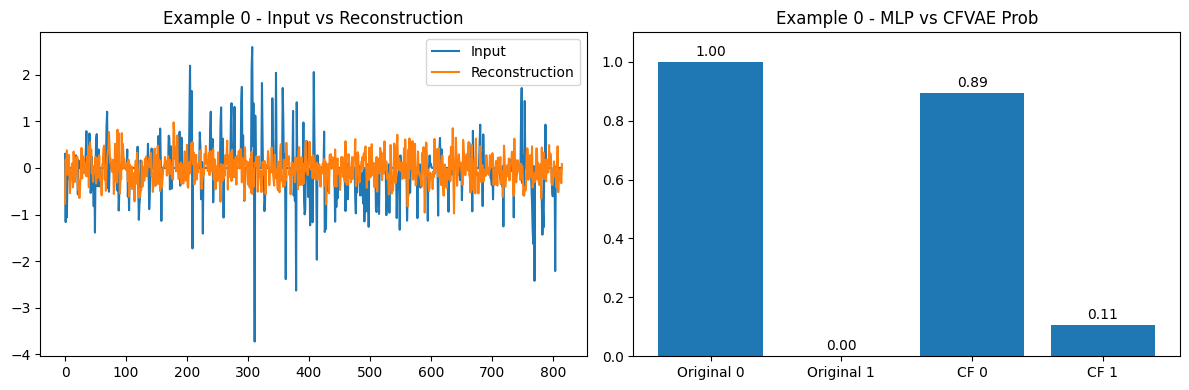

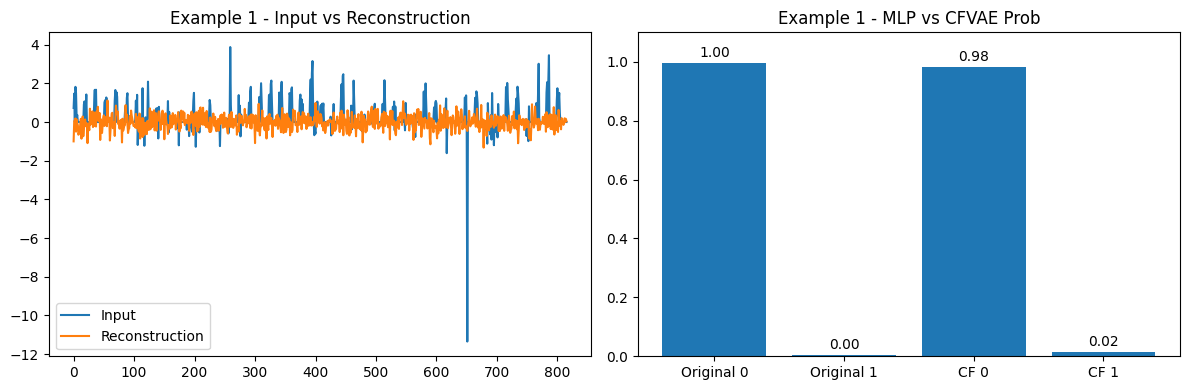

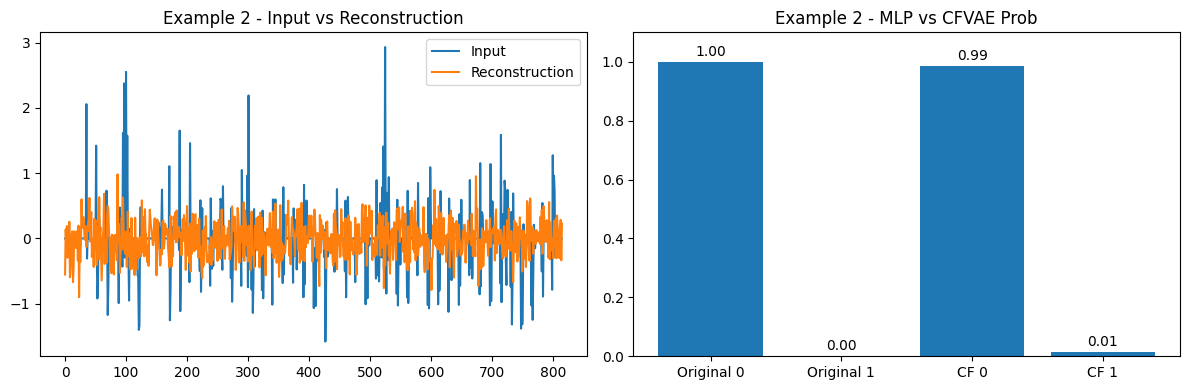

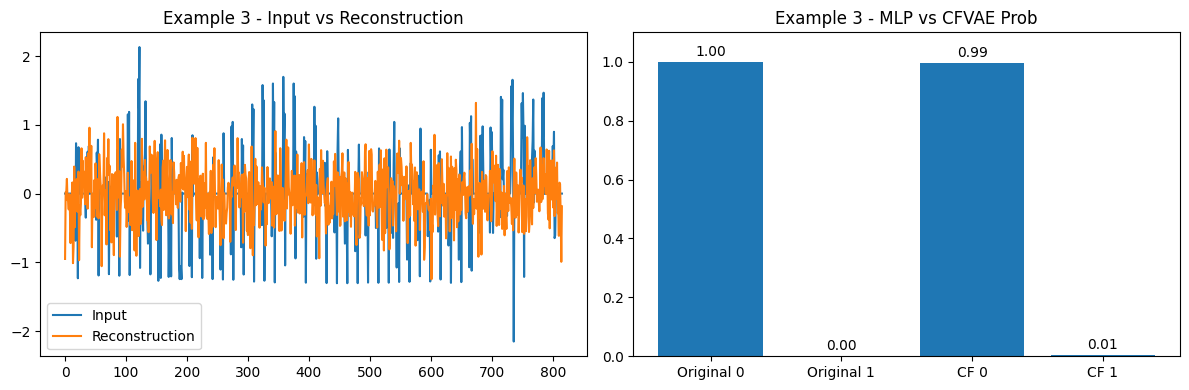

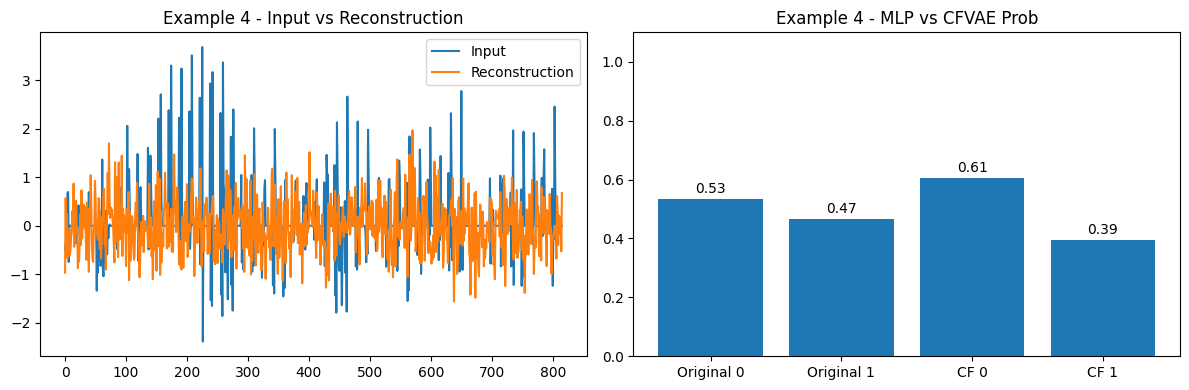

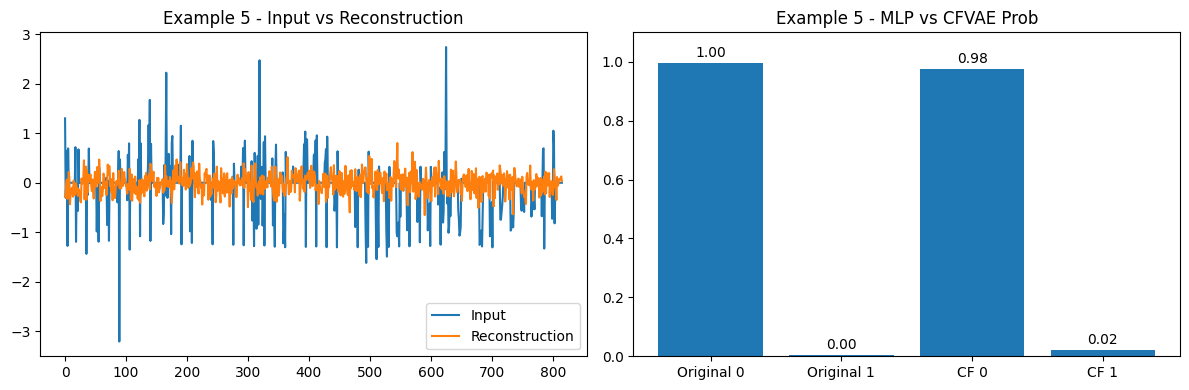

In [65]:

# === Visualization: Plot input vs. reconstruction and probabilities ===
def plot_example_recon_and_probs(model, bb_model, X, y, num=5):
    model.eval()
    bb_model.eval()
    with torch.no_grad():
        xb = X[:num].to(device).float() if isinstance(X, torch.Tensor) else torch.tensor(X[:num], device=device).float()
        yb = y[:num].to(device) if isinstance(y, torch.Tensor) else torch.tensor(y[:num], dtype=torch.long, device=device)


        recon, mu, logvar, clf_out_cf = model(xb)
        clf_out_cf = torch.softmax(clf_out_cf, dim=1)

        pred_orig_logits = bb_model(xb, xb)[1]
        pred_orig = torch.softmax(pred_orig_logits, dim=1)

        for i in range(num):
            plt.figure(figsize=(12, 4))

            # Input vs. Reconstructed
            plt.subplot(1, 2, 1)
            plt.plot(xb[i].cpu().view(-1).tolist(), label='Input')
            plt.plot(recon[i].cpu().view(-1).tolist(), label='Reconstruction')
            plt.title(f'Example {i} - Input vs Reconstruction')
            plt.legend()

            # Probabilities
            plt.subplot(1, 2, 2)
            bars = plt.bar(['Original 0', 'Original 1', 'CF 0', 'CF 1'],
                           pred_orig[i].cpu().tolist() + clf_out_cf[i].cpu().tolist())
            for bar in bars:
                yval = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')
            plt.ylim(0, 1.1)
            plt.title(f'Example {i} - MLP vs CFVAE Prob')

            plt.tight_layout()
            plt.show()

# === Aggregate Metrics ===
def compute_flip_rate(bb_model, model, X, y):
    model.eval()
    bb_model.eval()
    with torch.no_grad():
        xb = X.to(device).float()

        pred_orig = torch.argmax(bb_model(xb, xb)[1], dim=1)
        clf_out_cf = model(xb)[3]  # Only need CF output
        clf_out_cf = torch.nan_to_num(clf_out_cf, nan=0.0, posinf=1.0, neginf=-1.0)
        cf_preds = torch.argmax(clf_out_cf, dim=1)

        flips = (pred_orig != cf_preds).sum().item()
        flip_rate = flips / len(y)
        print(f"Counterfactual Flip Rate: {flip_rate:.4f} ({flips} of {len(y)})")
        return flip_rate

# === Final test eval ===
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path))
    test_loss, test_acc_cf, test_auc_cf = evaluate_cfvae(model, X_test, y_test)
    print(f"Final Test | Loss: {test_loss:.4f} | Acc: {test_acc_cf:.4f} | AUC: {test_auc_cf:.4f}")
    show_counterfactuals(model, bb_model, X_test, y_test, num=5)
    compute_flip_rate(bb_model, model, X_test, y_test)
    plot_example_recon_and_probs(model, bb_model, X_test, y_test, num=6)
else:
    print("No saved model found. Skipping final evaluation.")